# Prediction of logP values from chemical structures

logP is the log of the partition coefficient, which describes the proportion of a chemical which will be found in a hydrophobic phase (1-octonol) vs a hydrophillic phase (water). The measure is very useful in the prediction of where a chemical will go in a biological or environmental system. For example, in animals, blood carries hydrophillic materials throughout the body, but without other transport mechanisms, the chemical must also be able to pass through the hydrophobic phospholipid membrane to enter cells.
https://en.wikipedia.org/wiki/Partition_coefficient#Partition_coefficient_and_log_P

![1024px-Log_P_examples_01.png](1024px-Log_P_examples_01.png)
This image shows a selection of chemicals comparing experimental partition between brain/blood and octonol/water showing a relatively high correlation for chemicals without an explicit transporter or efflux mechanism.

log P (octanol/water) at the X-axis vers. log Pc (permeability coefficient of rat brain capillaries in cm per second) for various drugs, solvents and other compounds. Data taken from N. Bodor and P. Buchwald: Recent advances in the brain targeting of neuropharmaceuticals by chemical delivery systems. In: Adv Drug Deliv Rev 36, 1999, pp. 229-254.

## Goal

The goal of this project is to create a system that can take an arbitrary chemical as input and predict a probable logP value from it. This will allow us to make some predications about the properties of this chemical, its suitability for use as a drug and possible environmental fate.
Methods for estimating logP from chemical structures do exist and will be used for reference to see if the machine learning methods explored will improve on the predictions.

In [1]:
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.fprint import Fingerprint
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

import chem

Data collected from https://www.kaggle.com/matthewmasters/chemical-structure-and-logp 
This two column dataset contains only stereoscopic SMILES (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) encoded chemical structures and experimental logP values.

In [2]:
logP = pd.read_csv('/data/logP_dataset.csv')
logP.head()

,smiles,logp
0,C[C@H]([C@@H](C)Cl)Cl,2.3
1,C(C=CBr)N,0.3
2,CCC(CO)Br,1.3
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0
4,CCCOCCP,0.6


create 3d chemical structures from the SMILES strings. Functional code was abstracted out into a separate file for reusability.

In [3]:
logP['molecule'] = logP['smiles'].apply(chem.chem_3d_from_smiles)

[06:47:21] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:47:21] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:47:21] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[06:47:21] UFFTYPER: Unrecognized atom type: S_5+4 (1)
RDKit WARNING: [06:47:21] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:47:21] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:47:21] UFFTYPER: Unrecognized charge state for atom: 1
[06:47:21] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:47:22] UFFTYPER: Unrecognized charge state for atom: 3
[06:47:22] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [06:47:22] UFFTYPER: Unrecognized charge state for atom: 3
[06:47:22] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [06:47:23] UFFTYPER: Unrecognized charge state for atom: 2
[06:47:23] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:47:23] UFFTYPER: Warning: hybridization 

[06:47:32] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:47:32] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [06:47:32] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:47:32] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:47:32] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[06:47:32] UFFTYPER: Warning: hybridization set to SP3 for atom 5
RDKit ERROR: [06:47:32] UFFTYPER: Unrecognized charge state for atom: 3
[06:47:32] UFFTYPER: Unrecognized charge state for atom: 3
[06:47:32] UFFTYPER: Unrecognized charge state for atom: 5
RDKit ERROR: [06:47:32] UFFTYPER: Unrecognized charge state for atom: 5
RDKit ERROR: [06:47:32] UFFTYPER: Unrecognized charge state for atom: 4
[06:47:32] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:47:33] UFFTYPER: Unrecognized charge state for atom: 2
[06:47:33] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [06:47:33] UFFTYPER: Unrecognized char

RDKit WARNING: [06:47:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:47:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [06:47:41] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:47:41] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit ERROR: [06:47:41] UFFTYPER: Unrecognized charge state for atom: 2
[06:47:41] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:47:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:47:41] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [06:47:41] UFFTYPER: Unrecognized charge state for atom: 1
[06:47:41] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:47:42] UFFTYPER: Unrecognized charge state for atom: 1
[06:47:42] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:47:42] UFFTYPER: Unrecognized charge state for atom: 2
[06:47:42] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [06:47:42] UFFTYPER: U

RDKit ERROR: [06:47:50] UFFTYPER: Unrecognized charge state for atom: 1
[06:47:50] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [06:47:50] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:47:50] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit ERROR: [06:47:51] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[06:47:51] UFFTYPER: Unrecognized atom type: S_5+4 (1)
RDKit ERROR: [06:47:51] UFFTYPER: Unrecognized charge state for atom: 1
[06:47:51] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [06:47:51] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:47:51] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:47:51] UFFTYPER: Unrecognized charge state for atom: 2
[06:47:51] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [06:47:51] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[06:47:51] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[06:47:51] UFFTYPER: Warning: hybridization set to SP3 for atom 1
R

RDKit WARNING: [06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 5
RDKit WARNING: [06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit ERROR: [06:47:58] UFFTYPER: Unrecognized charge state for atom: 4
[06:47:58] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:47:58] UFFTYPER: Unrecognized charge state for atom: 5
[06:47:58] UFFTYPER: Unrecognized charge state for atom: 5
RDKit WARNING: [06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:47:58] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:47:58] UFFTYPER: Unrecognized charge state for atom: 5
[06:47:58] UFFTYPER: Unrecognized charge state for atom: 5
RDKit ERROR: [06:47

RDKit ERROR: [06:48:07] UFFTYPER: Unrecognized charge state for atom: 1
[06:48:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:48:07] UFFTYPER: Unrecognized charge state for atom: 3
[06:48:07] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [06:48:07] UFFTYPER: Unrecognized charge state for atom: 5
[06:48:07] UFFTYPER: Unrecognized charge state for atom: 5
RDKit WARNING: [06:48:07] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:07] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit WARNING: [06:48:07] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[06:48:07] UFFTYPER: Warning: hybridization set to SP3 for atom 5
RDKit ERROR: [06:48:07] UFFTYPER: Unrecognized charge state for atom: 1
[06:48:07] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:48:07] UFFTYPER: Unrecognized charge state for atom: 2
[06:48:07] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:48:07] UFFTYPER: Warning: hybrid

RDKit WARNING: [06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit ERROR: [06:48:15] UFFTYPER: Unrecognized charge state for atom: 2
[06:48:15] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [06:48:15] UFFTYPER: Unrecognized charge state for atom: 5
[06:48:15] UFFTYPER: Unrecognized charge state for atom: 5
RDKit WARNING: [06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit ERROR: [06:48:15] UFFTYPER: Unrecognized charge state for atom: 4
[06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:48:15] UFFTYPER: Unrecognized charge state for atom: 4
RDKit WARNING: [06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:15] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit WARNING: [06:

RDKit ERROR: [06:48:22] UFFTYPER: Unrecognized charge state for atom: 3
[06:48:22] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [06:48:22] UFFTYPER: Unrecognized charge state for atom: 3
[06:48:22] UFFTYPER: Unrecognized charge state for atom: 3
RDKit ERROR: [06:48:22] UFFTYPER: Unrecognized charge state for atom: 5
[06:48:22] UFFTYPER: Unrecognized charge state for atom: 5
RDKit ERROR: [06:48:22] UFFTYPER: Unrecognized atom type: C_ (0)
[06:48:22] UFFTYPER: Unrecognized atom type: C_ (0)
RDKit WARNING: [06:48:22] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:48:22] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:48:23] UFFTYPER: Unrecognized charge state for atom: 3
[06:48:23] UFFTYPER: Unrecognized charge state for atom: 3
[06:48:23] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit WARNING: [06:48:23] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit ERROR: [06:48:23] UFFTYPER: Unrecognized charge state for a

[06:48:32] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit WARNING: [06:48:32] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:48:32] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:48:32] UFFTYPER: Unrecognized charge state for atom: 4
[06:48:32] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:48:32] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:48:33] UFFTYPER: Unrecognized charge state for atom: 3
[06:48:33] UFFTYPER: Unrecognized charge state for atom: 3
RDKit WARNING: [06:48:33] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:48:33] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [06:48:33] UFFTYPER: Unrecognized charge state for atom: 1
[06:48:33] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [06:48:33] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:48:33] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [06:48:33] UFFTYPER: U

RDKit WARNING: [06:48:43] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:43] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit ERROR: [06:48:43] UFFTYPER: Unrecognized charge state for atom: 2
[06:48:43] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [06:48:44] UFFTYPER: Unrecognized charge state for atom: 2
[06:48:44] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:48:44] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:48:44] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:48:44] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:48:44] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:48:44] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:48:44] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:48:44] UFFTYPER: Unrecognized charge state for atom: 2
[06:48:44] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [06:48

RDKit WARNING: [06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit WARNING: [06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:50] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit WARNING: [06:48:51] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:48:51] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:48:51] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:51] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit ERROR: [06:48:51] UFFTYPER: Unrecognized charge state for atom: 4
[06:48:51] UFFTYPER: Unrecognized charge state

RDKit WARNING: [06:48:59] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:48:59] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit ERROR: [06:48:59] UFFTYPER: Unrecognized charge state for atom: 2
[06:48:59] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:48:59] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:48:59] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit ERROR: [06:48:59] UFFTYPER: Unrecognized charge state for atom: 1
[06:48:59] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:00] UFFTYPER: Unrecognized charge state for atom: 2
[06:49:00] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:49:00] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:49:00] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit WARNING: [06:49:00] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:49:00] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:49:00] UFFTYPER

RDKit WARNING: [06:49:08] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:49:08] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[06:49:09] UFFTYPER: Warning: hybridization set to SP3 for atom 3
RDKit ERROR: [06:49:09] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:09] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:10] UFFTYPER: Unrecognized charge state for atom: 4
[06:49:10] UFFTYPER: Unrecognized charge state for atom: 4
RDK

RDKit ERROR: [06:49:17] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:17] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:17] UFFTYPER: Unrecognized charge state for atom: 5
[06:49:17] UFFTYPER: Unrecognized charge state for atom: 5
RDKit ERROR: [06:49:17] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:17] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:17] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:17] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:18] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:18] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [06:49:18] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[06:49:18] UFFTYPER: Warning: hybridization set to SP3 for atom 4
RDKit ERROR: [06:49:19] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[06:49:19] UFFTYPER: Unrecognized atom type: S_5+4 (1)
RDKit WARNING: [06:49:19] UFFTYPER: Warning: hybridization set to SP3 for a

RDKit ERROR: [06:49:28] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:28] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:28] UFFTYPER: Unrecognized charge state for atom: 4
[06:49:28] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:49:28] UFFTYPER: Unrecognized charge state for atom: 4
[06:49:28] UFFTYPER: Unrecognized charge state for atom: 4
RDKit WARNING: [06:49:28] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:49:28] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit ERROR: [06:49:28] UFFTYPER: Unrecognized charge state for atom: 4
[06:49:28] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:49:28] UFFTYPER: Unrecognized charge state for atom: 2
[06:49:28] UFFTYPER: Unrecognized charge state for atom: 2
RDKit WARNING: [06:49:28] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[06:49:28] UFFTYPER: Warning: hybridization set to SP3 for atom 2
RDKit WARNING: [06:49:28] UFFTYPER: Warning: hybrid

[06:49:35] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:35] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:35] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [06:49:35] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [06:49:35] UFFTYPER: Unrecognized charge state for atom: 1
[06:49:35] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [06:49:35] UFFTYPER: Unrecognized charge state for atom: 4
[06:49:35] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [06:49:35] UFFTYPER: Unrecognized charge state for atom: 4
[06:49:35] UFFTYPER: Unrecognized charge state for atom: 4


In [4]:
logP.head()

,smiles,logp,molecule
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f466d809880>
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f466d8097c0>
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f466d809760>
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7f466d809700>
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7f466d8096a0>


After conversion, check to ensure that there is usable data for all records in the data set

In [5]:
logP.isna().sum()

smiles      0
logp        0
molecule    0
dtype: int64

generate 3d descriptor fingerprints

In [6]:
logP['fingerprint'] = logP['molecule'].apply(lambda mol: Fingerprint.from_rdkit(Chem.GetMorganFingerprintAsBitVect(mol, 2)))

Chemical fingerprints are very low density structures, making them very difficult to train models on. To increase the density (at only minimal loss of data), the fingerprints are folded into 1024 bits.

In [7]:
db = FingerprintDatabase(fp_type=Fingerprint, name="logP")
db.add_fingerprints(logP['fingerprint'])
folded = db.fold(1024)
print(folded.get_density())

0.014987995165982204


Display the fit of the rdkit generated logP value vs the experimental data from the dataset. Rdkit uses the Wildman-Crippen method.

Prediction of Physicochemical Parameters by Atomic Contributions
Scott A. Wildman and Gordon M. Crippen
Journal of Chemical Information and Computer Sciences 1999 39 (5), 868-873
DOI: 10.1021/ci990307l

In [8]:
logP['rdkit_logp'] = logP['molecule'].apply(Descriptors.MolLogP)

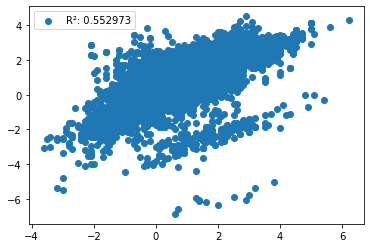

In [9]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], label='R²: %f' % r2)
pyplot.legend()
pyplot.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(logP['fingerprint'], logP['logp'], test_size=0.2, random_state=42)


In [11]:
from e3fp.fingerprint.metrics.array_metrics import tanimoto
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.fprint import Fingerprint
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [26]:
models = [
    ('SVR', SVR(kernel=tanimoto)),
    ('Linear SVR', LinearSVR()), 
    ('SGD', SGDRegressor()), 
    ('Ridge', Ridge()),
    ('ElasticNet', ElasticNet())
]
X_sample, y_sample = resample(logP['fingerprint'], logP['logp'], n_samples=100, random_state=42)

sample_db = FingerprintDatabase(fp_type=Fingerprint, name="sample")
sample_db.add_fingerprints(X_sample.values)
folded_sample_db = sample_db.fold(1024)

scoring = ['explained_variance', 'max_error', 'r2']
# r2, mae, mse, rmse, rmsle

print(logP['logp'].iloc[0])
fp_test = FingerprintDatabase(fp_type=Fingerprint, name="fp_test")
fp_test.add_fingerprints([logP['fingerprint'].iloc[0]])

results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    results.append(model_selection.cross_validate(model, sample_db.array, y_sample, cv=kfold, scoring=scoring))
    clf = model.fit(sample_db.array, y_sample)
    print('%s: %f' % (name, clf.predict(fp_test.array)))

model_results = pd.DataFrame(results)


2.3
SVR: 2.199941
Linear SVR: 2.232647
SGD: 2.149982
Ridge: 2.269006
ElasticNet: 1.171000


                                            fit_time  \
0  [0.008547306060791016, 0.011859416961669922, 0...   
1  [0.009279251098632812, 0.0065691471099853516, ...   
2  [0.010587692260742188, 0.01282048225402832, 0....   
3  [0.025226593017578125, 0.025115013122558594, 0...   
4  [0.009912729263305664, 0.007377147674560547, 0...   

                                          score_time  \
0  [0.008833646774291992, 0.009960412979125977, 0...   
1  [0.00616765022277832, 0.005359172821044922, 0....   
2  [0.0060155391693115234, 0.005636692047119141, ...   
3  [0.00477910041809082, 0.004704713821411133, 0....   
4  [0.005095481872558594, 0.007443428039550781, 0...   

                             test_explained_variance  \
0  [0.2880315168829902, 0.4737529165559621, 0.534...   
1  [0.3294361955006295, 0.5282996363344237, 0.598...   
2  [0.3271732799527881, 0.5770640134962945, 0.595...   
3  [0.3356194422680139, 0.5325111840665541, 0.664...   
4  [-2.220446049250313e-16, -2.220446049250313

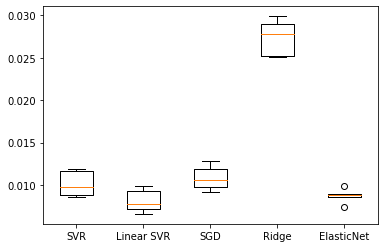

Score time


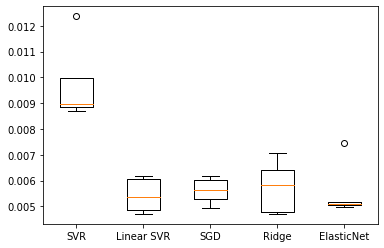

Explained Variance


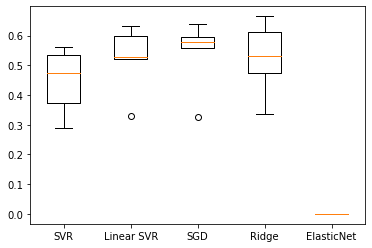

Max Error


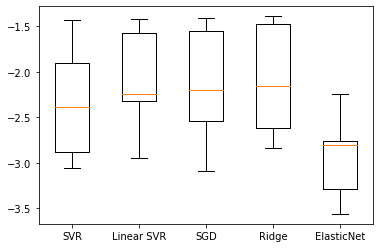

R²


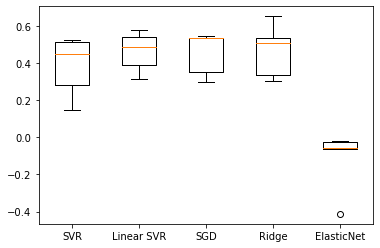

In [57]:
import seaborn as sns
labels = labels=list(map(lambda m: m[0], models))
print(model_results.head(5))

print('Fit time')
pyplot.boxplot(model_results['fit_time'], labels=list(map(lambda m: m[0], models)))
pyplot.show()

print('Score time')
pyplot.boxplot(model_results['score_time'], labels=list(map(lambda m: m[0], models)))
pyplot.show()

print('Explained Variance')
pyplot.boxplot(model_results['test_explained_variance'], labels=list(map(lambda m: m[0], models)))
pyplot.show()

print('Max Error')
pyplot.boxplot(model_results['test_max_error'], labels=list(map(lambda m: m[0], models)))
pyplot.show()

print('R²')
pyplot.boxplot(model_results['test_r2'], labels=list(map(lambda m: m[0], models)))
pyplot.show()
                     
# sns.barplot(data=model_results)

In [32]:
model = LinearSVR(max_iter=1000, dual=True)
X_train_db = FingerprintDatabase(fp_type=Fingerprint, name="sample")
X_train_db.add_fingerprints(X_train.values)

clf = model.fit(X_train_db.array, y_train)

In [43]:
import pickle

with open('model.p', mode='wb') as file:
    pickle.dump(clf, file)

In [47]:
X_test_db = FingerprintDatabase(fp_type=Fingerprint, name="test")
X_test_db.add_fingerprints(X_test.values)
model.score(X_test_db.array, y_test)

0.8287526635877844

In [48]:
logP['model_logP'] = model.predict(db.array)

In [52]:
logP.head(20)

,smiles,logp,molecule,fingerprint,rdkit_logp,model_logP
0,C[C@H]([C@@H](C)Cl)Cl,2.3,<rdkit.Chem.rdchem.Mol object at 0x7f466d809880>,"(False, False, False, False, False, False, Fal...",2.24100,1.797400
1,C(C=CBr)N,0.3,<rdkit.Chem.rdchem.Mol object at 0x7f466d8097c0>,"(False, False, False, False, False, False, Fal...",0.85370,0.631697
2,CCC(CO)Br,1.3,<rdkit.Chem.rdchem.Mol object at 0x7f466d809760>,"(False, False, False, False, False, False, Fal...",1.15220,1.290744
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7f466d809700>,"(False, False, False, False, False, False, Fal...",1.55900,1.743834
4,CCCOCCP,0.6,<rdkit.Chem.rdchem.Mol object at 0x7f466d8096a0>,"(False, False, False, False, False, False, Fal...",1.28810,0.832529
5,C(C(F)(F)F)F,1.7,<rdkit.Chem.rdchem.Mol object at 0x7f466d8098e0>,"(False, False, False, False, False, False, Fal...",1.51820,1.696169
6,[2H]C([2H])C(C)(C)Cl,1.8,<rdkit.Chem.rdchem.Mol object at 0x7f466d809940>,"(False, False, False, False, False, False, Fal...",2.02370,1.879793
7,CCCC(CI)O,2.0,<rdkit.Chem.rdchem.Mol object at 0x7f466d8099a0>,"(False, False, False, False, False, False, Tru...",1.58240,1.989052
8,CCCCCC[CH+]C,3.9,<rdkit.Chem.rdchem.Mol object at 0x7f466d809a00>,"(False, False, False, False, False, False, Fal...",3.18099,4.521556
9,C(CO)NCCO,-1.4,<rdkit.Chem.rdchem.Mol object at 0x7f466d809a60>,"(False, False, False, False, False, False, Fal...",-1.43940,-0.764270


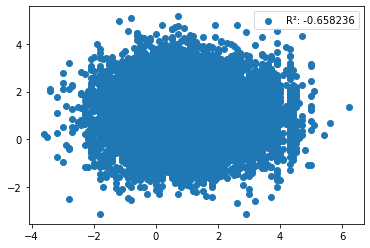

In [58]:
r2 = r2_score(logP['logp'], logP['model_logP'])
pyplot.scatter(logP['logp'], logP['model_logP'], label='R²: %f' % r2)
pyplot.legend()
pyplot.show()

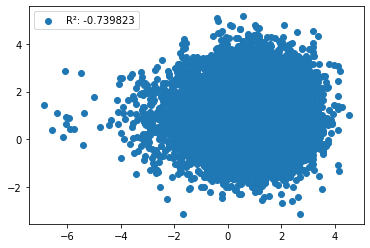

In [59]:
r2 = r2_score(logP['rdkit_logp'], logP['model_logP'])
pyplot.scatter(logP['rdkit_logp'], logP['model_logP'], label='R²: %f' % r2)
pyplot.legend()
pyplot.show()

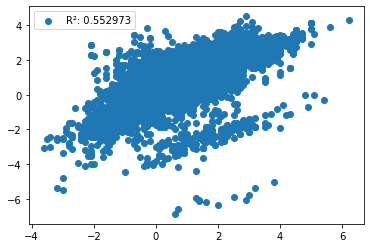

In [60]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], label='R²: %f' % r2)
pyplot.legend()
pyplot.show()

References:

N. Bodor and P. Buchwald: Recent advances in the brain targeting of neuropharmaceuticals by chemical delivery systems. In: Adv Drug Deliv Rev 36, 1999, pp. 229-254.

Prediction of Physicochemical Parameters by Atomic Contributions
Scott A. Wildman and Gordon M. Crippen
Journal of Chemical Information and Computer Sciences 1999 39 (5), 868-873
DOI: 10.1021/ci990307l